In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Load data
customers_data = pd.read_csv("Customers.csv")
transactions_data = pd.read_csv("Transactions.csv")
products_data = pd.read_csv("Products.csv")

In [9]:
# Merge datasets
merged_data = pd.merge(transactions_data, customers_data, on="CustomerID", how="left")
merged_data = pd.merge(merged_data, products_data, on="ProductID", how="left")

In [10]:
# Feature Engineering
# Extract year and month from SignupDate
customers_data["SignupDate"] = pd.to_datetime(customers_data["SignupDate"])
customers_data["SignupYear"] = customers_data["SignupDate"].dt.year
customers_data["SignupMonth"] = customers_data["SignupDate"].dt.month

In [11]:
# Aggregate transaction data
customer_transaction_data = merged_data.groupby("CustomerID").agg({
    "TransactionID": "count",   # Total transactions
    "TotalValue": ["sum", "mean"],  # Total and average spending
    "Quantity": "sum"  # Total quantity purchased
}).reset_index()
customer_transaction_data.columns = ["CustomerID", "TotalTransactions", "TotalSpending", "AverageSpending", "TotalQuantity"]

# Merge back with customer data
customer_features = pd.merge(customers_data, customer_transaction_data, on="CustomerID", how="left")
customer_features = customer_features.fillna(0)  # Replace NaN with 0 for customers without transactions

# One-hot encode region
customer_features = pd.get_dummies(customer_features, columns=["Region"], drop_first=True)

# Select features for clustering
X = customer_features.drop(columns=["CustomerID", "CustomerName", "SignupDate"])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Clustering
cluster_range = range(2, 11)  # Trying 2 to 10 clusters
db_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    db_index = davies_bouldin_score(X_scaled, cluster_labels)
    db_scores.append(db_index)

# Find the optimal number of clusters
optimal_clusters = cluster_range[db_scores.index(min(db_scores))]
print(f"Optimal number of clusters: {optimal_clusters}")

Optimal number of clusters: 6


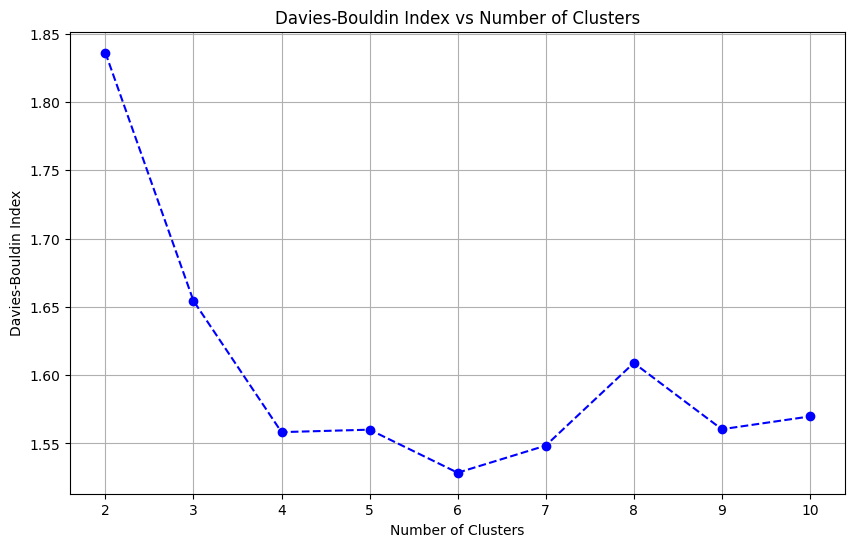

In [13]:
# Final clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(X_scaled)

# Visualize DB Index
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, db_scores, marker="o", linestyle="--", color="b")
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.grid()
plt.show()

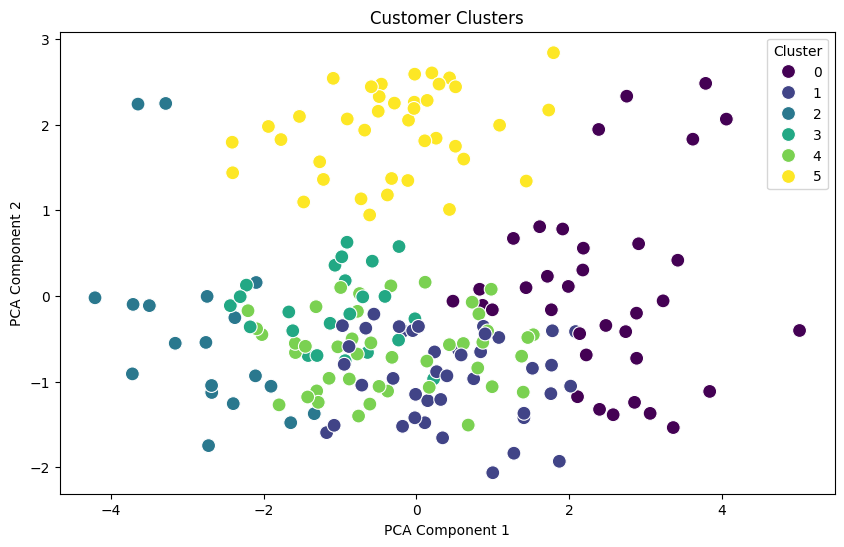

In [14]:
# Visualize Clusters (using PCA for 2D visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=customer_features["Cluster"], palette="viridis", s=100)
plt.title("Customer Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()